# Intro to Sparse Data and Embeddings

In [8]:
from jupyterthemes import jtplot 
import collections
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython import display
from sklearn import metrics

jtplot.style()
tf.logging.set_verbosity(tf.logging.ERROR)
train_url = 'https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/train.tfrecord'
train_path = tf.keras.utils.get_file(train_url.split('/')[-1], train_url)
test_url = 'https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/test.tfrecord'
test_path = tf.keras.utils.get_file(test_url.split('/')[-1], test_url)

In [9]:
def _parse_function(record):
    """
    Extracts feature and labels.
    
    Args:
        record: File path to TFRecord file
    Returns:
        A 'tuple' '(labels, featuers)':
            labels: Tensor with corresponding labels
            features: Dict of tensors representing the features
    """
    features = {
        "terms": tf.VarLenFeature(dtype=tf.string), # terms are strings of varying lengths,
        "labels": tf.FixedLenFeature(shape=[1], dtype=tf.float32)
    }
    
    parsed_features = tf.parse_single_example(record, features)
    
    terms = parsed_features['terms'].values
    labels = parsed_features['labels']
    
    return {'terms':terms}, labels

In [11]:
# create DataSet object
ds = tf.data.TFRecordDataset(train_path)
# map features and labels with parse function
ds = ds.map(_parse_function)
ds

<MapDataset shapes: ({terms: (?,)}, (1,)), types: ({terms: tf.string}, tf.float32)>

In [12]:
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)

({'terms': array([b'but', b'it', b'does', b'have', b'some', b'good', b'action',
         b'and', b'a', b'plot', b'that', b'is', b'somewhat', b'interesting',
         b'.', b'nevsky', b'acts', b'like', b'a', b'body', b'builder',
         b'and', b'he', b'isn', b"'", b't', b'all', b'that', b'attractive',
         b',', b'in', b'fact', b',', b'imo', b',', b'he', b'is', b'ugly',
         b'.', b'(', b'his', b'acting', b'skills', b'lack', b'everything',
         b'!', b')', b'sascha', b'is', b'played', b'very', b'well', b'by',
         b'joanna', b'pacula', b',', b'but', b'she', b'needed', b'more',
         b'lines', b'than', b'she', b'was', b'given', b',', b'her',
         b'character', b'needed', b'to', b'be', b'developed', b'.',
         b'there', b'are', b'way', b'too', b'many', b'men', b'in', b'this',
         b'story', b',', b'there', b'is', b'zero', b'romance', b',', b'too',
         b'much', b'action', b',', b'and', b'way', b'too', b'dumb', b'of',
         b'an', b'ending', b'.', b'

In [13]:
# create input_fn that parses the tf.Examples from the given files, 
# and split them into features and targets
def _input_fn(input_filenames, num_epochs=None, shuffle=True):
    
    ds = tf.data.TFRecordDataset(input_filenames)
    ds = ds.map(_parse_function)
    
    if shuffle:
        ds = ds.shuffle(10000)
        
    # our feature data is variable-length, so we pad and batch
    # each field of the dataset structure to whatever size is necessary
    ds = ds.padded_batch(25, ds.output_shapes)
    ds = ds.repeat(num_epochs)
    
    # return next batch
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

## Task 1: Use a Linear  Model with Sparse Inputs and an Explicit Vocabulary

In [14]:
# 50 informative terms that compose our model vocabulary 
informative_terms = ("bad", "great", "best", "worst", "fun", "beautiful",
                     "excellent", "poor", "boring", "awful", "terrible",
                     "definitely", "perfect", "liked", "worse", "waste",
                     "entertaining", "loved", "unfortunately", "amazing",
                     "enjoyed", "favorite", "horrible", "brilliant", "highly",
                     "simple", "annoying", "today", "hilarious", "enjoyable",
                     "dull", "fantastic", "poorly", "fails", "disappointing",
                     "disappointment", "not", "him", "her", "good", "time",
                     "?", ".", "!", "movie", "film", "action", "comedy",
                     "drama", "family")

terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", vocabulary_list=informative_terms)

In [16]:
my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

feature_columns = [terms_feature_column]

classifier = tf.estimator.LinearClassifier(
    feature_columns=feature_columns,
    optimizer=my_optimizer)

classifier.train(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000)

evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print("---")

print("Test set metrics:")
evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([test_path]),
    steps=1000)
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.78904
accuracy_baseline 0.5
auc 0.8723858
auc_precision_recall 0.8633868
average_loss 0.45013484
label/mean 0.5
loss 11.253371
prediction/mean 0.509017
global_step 1000
---
Test set metrics:
accuracy 0.785
accuracy_baseline 0.5
auc 0.86992747
auc_precision_recall 0.8604129
average_loss 0.4518627
label/mean 0.5
loss 11.296567
prediction/mean 0.5075821
global_step 1000
---


## Task 2: Use a Deep Neural Network (DNN) Model

In [18]:
classifier = tf.estimator.DNNClassifier(
    feature_columns=[tf.feature_column.indicator_column(terms_feature_column)],
    hidden_units=[20,20],
    optimizer=my_optimizer)

classifier.train(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000)

evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print("---")

print("Test set metrics:")
evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([test_path]),
    steps=1000)
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.78748
accuracy_baseline 0.5
auc 0.87328154
auc_precision_recall 0.8660304
average_loss 0.4458464
label/mean 0.5
loss 11.14616
prediction/mean 0.48554677
global_step 1000
---
Test set metrics:
accuracy 0.78172
accuracy_baseline 0.5
auc 0.8703055
auc_precision_recall 0.86240315
average_loss 0.44941112
label/mean 0.5
loss 11.235278
prediction/mean 0.48477292
global_step 1000
---


## Task 3: Use an Embedding with a DNN Model

In [20]:
classifier = tf.estimator.DNNClassifier(
    feature_columns=[tf.feature_column.embedding_column(terms_feature_column, 2)],
    hidden_units=[20,20],
    optimizer=my_optimizer)

classifier.train(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000)

evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print("---")

print("Test set metrics:")
evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([test_path]),
    steps=1000)
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.7814
accuracy_baseline 0.5
auc 0.8696148
auc_precision_recall 0.8583567
average_loss 0.45862216
label/mean 0.5
loss 11.465553
prediction/mean 0.5454261
global_step 1000
---
Test set metrics:
accuracy 0.78192
accuracy_baseline 0.5
auc 0.8694579
auc_precision_recall 0.85788834
average_loss 0.45839965
label/mean 0.5
loss 11.459991
prediction/mean 0.5444817
global_step 1000
---


## Task 4: Convince yourself there's actually an embedding in there

In [22]:
classifier.get_variable_names()

['dnn/hiddenlayer_0/bias',
 'dnn/hiddenlayer_0/bias/t_0/Adagrad',
 'dnn/hiddenlayer_0/kernel',
 'dnn/hiddenlayer_0/kernel/t_0/Adagrad',
 'dnn/hiddenlayer_1/bias',
 'dnn/hiddenlayer_1/bias/t_0/Adagrad',
 'dnn/hiddenlayer_1/kernel',
 'dnn/hiddenlayer_1/kernel/t_0/Adagrad',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights/t_0/Adagrad',
 'dnn/logits/bias',
 'dnn/logits/bias/t_0/Adagrad',
 'dnn/logits/kernel',
 'dnn/logits/kernel/t_0/Adagrad',
 'global_step']

In [23]:
classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights').shape

(50, 2)

In [30]:
print(classifier.get_variable_value('dnn/hiddenlayer_0/kernel').shape)
print(classifier.get_variable_value('dnn/hiddenlayer_1/kernel').shape)
print(classifier.get_variable_value('dnn/logits/kernel').shape)

(2, 20)
(20,)
(20, 20)
(20, 1)


## Task 5: Examine the Embedding

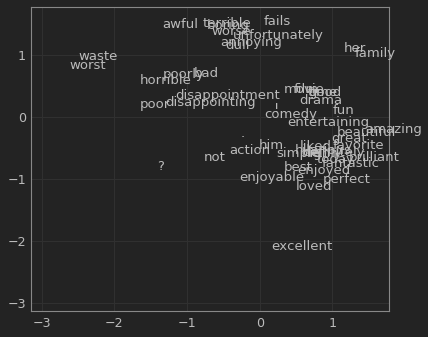

In [32]:
import numpy as np
import matplotlib.pyplot as plt

embedding_matrix = classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')

for term_index in range(len(informative_terms)):
    # create a one hot encoding for our term.  It has 0s everywhere, except single 1 in
    # coordinate that corresponds to that term
    term_vector = np.zeros(len(informative_terms))
    term_vector[term_index] = 1
    # project one-hot vector into embedding space
    embedding_xy = np.matmul(term_vector, embedding_matrix)
    plt.text(embedding_xy[0], embedding_xy[1], informative_terms[term_index])

# setup plot
plt.rcParams["figure.figsize"] = (15,15)
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show()

## Task 6: Try to improve the model's performance

In [34]:
!wget https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/terms.txt -O /tmp/terms.txt

--2018-03-31 13:40:52--  https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/terms.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.11.176, 2607:f8b0:4007:804::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.11.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 253538 (248K) [text/plain]
Saving to: ‘/tmp/terms.txt’

/tmp/terms.txt      100%[===================>] 247.60K  --.-KB/s    in 0.1s    

2018-03-31 13:40:53 (2.37 MB/s) - ‘/tmp/terms.txt’ saved [253538/253538]



In [35]:
# Create a feature column from "terms", using a full vocabulary file.
informative_terms = None
with open("/tmp/terms.txt", 'r') as f:
  # Convert it to a set first to remove duplicates.
  informative_terms = list(set(f.read().split()))

In [38]:
terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", 
                                                                                 vocabulary_list=informative_terms)
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    hidden_units=[20,20],
    optimizer=my_optimizer)

classifier.train(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000)

evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print("---")

print("Test set metrics:")
evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([test_path]),
    steps=1000)
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.523
accuracy_baseline 0.5
auc 0.5425173
auc_precision_recall 0.54934156
average_loss 0.69241554
label/mean 0.5
loss 17.310389
prediction/mean 0.5023627
global_step 1000
---
Test set metrics:
accuracy 0.51956
accuracy_baseline 0.5
auc 0.53803736
auc_precision_recall 0.54149985
average_loss 0.69257224
label/mean 0.5
loss 17.314306
prediction/mean 0.50240743
global_step 1000
---
